# <b>Производная, градиент и градиентный спуск</b>

Поработать с понятием производной и градиента, а также реализуем функции градиентного спуска и его вариации.

__Напоминание:__
Производной функции $f$ в точке $x$ называется выражение

$$\lim_{h→0}\frac{f(x+h)−f(x)}{h}$$
Или, что то же самое,
$$\lim_{x→x_0}\frac{f(x)−f(x_0)}{x-x_0}$$

Если такой предел существует, то и производная существует (и равна этому пределу).

In [1]:
from copy import copy, deepcopy

import numpy as np
import matplotlib.pyplot as plt

# Функция заданной производной

Напишем python-функцию, которая в качестве аргумента принимает:

числовую функцию $f$, у которой необходимо вычислить производную
число $\varepsilon$ --- его необходимо использовать в качестве "малого шага" для приближённого вычисления производной.
Функция должна в свою очередь возвращать числовую функцию $f'$, равную производной функции $f$.

Данная функция не будет вычислять эту самую производную аналитически. Производную вычислим по формуле $$f'(x)\approx \frac{f(x+\varepsilon) - f(x)}{\varepsilon}.$$
​

In [2]:
def numerical_derivative_1d(func, epsilon):
    """
    Функция для приближённого вычисления производной функции одной переменной. 
    :param func: float -> float — произвольная дифференцируемая функция
    :param epsilon: float — максимальная величина приращения по оси Ох
    :return: другая функция, которая приближённо вычисляет производную в точке
    """
    def deriv_func(x):
        """
        :param x: float — точка, в которой нужно вычислить производную
        :return: приближённое значение производной в этой точке
        """
        return (func(x + epsilon) - func(x)) / epsilon
        
    return deriv_func

In [3]:
# Проверим себя!
def polynom_to_prime(x):
    return 20 * x**5 + x**3 - 5 * x**2 + 2 * x + 2.0


def primed_poly(x):
    return 100 * x**4 + 3 * x**2 -10 * x + 2.0


approx_deriv = numerical_derivative_1d(polynom_to_prime, 1e-5)

grid = np.linspace(-2, 2, 100)
right_flag = True
tol = 0.05
debug_print = []

for x in grid:
    estimation_error = abs(primed_poly(x) - approx_deriv(x)) 
    if estimation_error > tol:
        debug_print.append((estimation_error, primed_poly(x), approx_deriv(x)))
        right_flag = False

if not right_flag:
    print("Что-то не то...")
    print(debug_print)
    plt.plot(grid, primed_poly(grid), label="Истинная производная")
    plt.plot(grid, approx_deriv(grid), label="Численное приближение")
    plt.legend()

print(str(right_flag))

True


# Нахождение минимума функции с помощью градиентного спуска

Найдме минимум функций с помощью градиентного спуска.

Нам на вход подаются функция `func`, ее производная `deriv` (*), а также начальная точка `start`, на выходе - точка локального минимума.

В первой реализации градиентного спуска предположим, что на вход подаются функции с единственным, глобальным минимумом. Перед тем, как писать код, ответьте себе на следующие вопросы:

* Как понять, что пора остановиться? Это может зависеть от градиента или расстояния между двумя соседними шагами алгоритма, так и от числа уже выполненных итераций.
* Как правильно менять величину шага (`learning rate`) от итерации к итерации?

В этом пункте гарантируется, что существует решение, использующее обычный градиентный спуск с фиксированным learning rate и наперёд заданным количеством итераций. 

На каждой итерации вызывем `callback(x, f(x))`, где `x` это результат шага градиентного спуска.   
Это нужно для отрисовки шагов алгоритма.

In [4]:
def grad_descent_v1(f, deriv, x0=None, lr=0.1, iters=100, callback=None):
    """ 
    Реализация градиентного спуска для функций с одним локальным минимумом,
    совпадающим с глобальным. Все тесты будут иметь такую природу.
    :param func: float -> float — функция 
    :param deriv: float -> float — её производная
    :param x0: float — начальная точка
    :param lr: float — learning rate
    :param iters: int — количество итераций
    :param callback: callable — функция логирования
    """

    if x0 is None:
        # Если точка не дана, сгенерируем случайную
        # из стандартного нормального распределения.
        # При таком подходе начальная точка может быть
        # любой, а не только из какого-то ограниченного диапазона
        # np.random.seed(179)
        x0 = np.random.uniform()

    x = x0

    i = 0
    while (i < iters) or (abs(lr * deriv(x)) > lr):
        x -= lr * deriv(x)
        callback(x, f(x))  # не забываеv логировать
        i += 1

    return x

# Отрисовка и тесты

In [5]:
def plot_convergence_1d(func, x_steps, y_steps, ax, grid=None, title=""):
    """
    Функция отрисовки шагов градиентного спуска. 
    :param func: функция, которая минимизируется градиентным спуском
    :param x_steps: np.array(float) — шаги алгоритма по оси Ox
    :param y_steps: np.array(float) — шаги алгоритма по оси Оу
    :param ax: холст для отрисовки графика
    :param grid: np.array(float) — точки отрисовки функции func
    :param title: str — заголовок графика
    """
    ax.set_title(title, fontsize=16, fontweight="bold")

    if grid is None:
        grid = np.linspace(np.min(x_steps), np.max(x_steps), 100)

    fgrid = [func(item) for item in grid]
    ax.plot(grid, fgrid)
    yrange = np.max(fgrid) - np.min(fgrid)

    arrow_kwargs = dict(linestyle="--", color="grey", alpha=0.4)
    for i, _ in enumerate(x_steps):
        if i + 1 < len(x_steps):
            ax.arrow(
                x_steps[i], y_steps[i], 
                x_steps[i + 1] - x_steps[i],
                y_steps[i + 1] - y_steps[i], 
                **arrow_kwargs
            )

    n = len(x_steps)
    color_list = [(i / n, 0, 0, 1 - i / n) for i in range(n)]
    ax.scatter(x_steps, y_steps, c=color_list)
    ax.scatter(x_steps[-1], y_steps[-1], c="red")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")


class LoggingCallback:
    """
    Класс для логирования шагов градиентного спуска. 
    Сохраняет точку (x, f(x)) на каждом шаге.
    Пример использования в коде: callback(x, f(x))
    """
    def __init__(self):
        self.x_steps = []
        self.y_steps = []

    def __call__(self, x, y):
        self.x_steps.append(x)
        self.y_steps.append(y)


def test_convergence_1d(grad_descent, test_cases, tol=1e-2, axes=None, grid=None):
    """
    Функция для проверки корректности нашего решения в одномерном случае.
    :param grad_descent: ваша реализация градиентного спуска
    :param test_cases: dict(dict), тесты в формате dict с такими ключами:
        - "func" — функция (обязательно)
        - "deriv" — её производная (обязательно)
        - "start" — начальная точка start (м.б. None) (опционально) 
        - "low", "high" — диапазон для выбора начальной точки (опционально)
        - "answer" — ответ (обязательно)
    При желании вы можете придумать и свои тесты.
    :param tol: предельное допустимое отклонение найденного ответа от истинного
    :param axes: матрица холстов для отрисовки, по ячейке на тест
    :param grid: np.array(float), точки на оси Ох для отрисовки тестов
    :return: флаг, корректно ли пройдены тесты, и дебажный вывод в случае неудачи
    """
    right_flag = True
    debug_log = []
    for i, key in enumerate(test_cases.keys()):
        # Формируем входные данные и ответ для алгоритма.
        answer = test_cases[key]["answer"]
        test_input = deepcopy(test_cases[key])
        del test_input["answer"]
        # Запускаем сам алгоритм.
        callback = LoggingCallback()  # Не забываем про логирование
        res_point = grad_descent(*test_input.values(), callback=callback)
        # Отрисовываем результаты.
        if axes is not None:
            ax = axes[np.unravel_index(i, shape=axes.shape)]
            x_steps = np.array(callback.x_steps)
            y_steps = np.array(callback.y_steps)
            plot_convergence_1d(
                test_input["func"], x_steps, y_steps, 
                ax, grid, key
            )
            ax.axvline(answer, 0, linestyle="--", c="red",
                        label=f"true answer = {answer}")
            ax.axvline(res_point, 0, linestyle="--", c="xkcd:tangerine", 
                        label=f"estimate = {np.round(res_point, 3)}")
            ax.legend(fontsize=16)
        # Проверяем, что найдення точка достаточно близко к истинной
        if abs(answer - res_point) > tol or np.isnan(res_point):
            debug_log.append(
                f"Тест '{key}':\n"
                f"\t- ответ: {answer}\n"
                f"\t- вывод алгоритма: {res_point}"
            )
            right_flag = False
    return right_flag, debug_log

Не сошлось. Дебажный вывод:
Тест 'third_power':
	- ответ: 1.0
	- вывод алгоритма: 0.9687157755223371


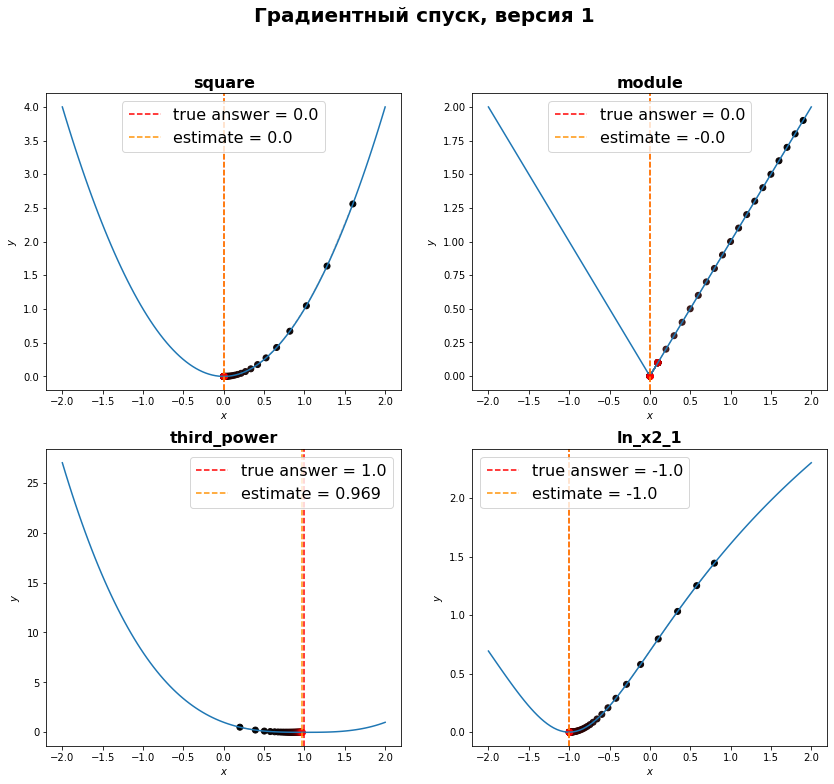

In [6]:
test_cases = {
    "square": {
        "func" : lambda x: x * x, 
        "deriv" : lambda x: 2 * x, 
        "start" : 2, 
        "answer" : 0.0
    },
    "module": {
        "func" : lambda x: abs(x),  
        "deriv" : lambda x: 1 if x > 0 else -1,
        "start" : 2, 
        "answer" : 0.0
    },
    "third_power": {
        "func" : lambda x: abs((x - 1)**3),
        "deriv" : lambda x: 3 * (x - 1)**2 * np.sign(x-1),
        "start" : -1, 
        "answer" : 1.0
    },
    "ln_x2_1": {
        "func" : lambda x: np.log((x + 1)**2 + 1),  
        "deriv" : lambda x: 2 * (x + 1) / (x**2 +1), 
        "start" : 1, 
        "answer" : -1.0
    }
}



tol = 1e-2  # желаемая точность 
fig, axes = plt.subplots(2,2, figsize=(14, 12))
fig.suptitle("Градиентный спуск, версия 1", fontweight="bold", fontsize=20)
grid = np.linspace(-2, 2, 100)

is_correct, debug_log = test_convergence_1d(
    grad_descent_v1, test_cases, tol, 
    axes, grid
)
if not is_correct:
    print("Не сошлось. Дебажный вывод:")
    for log_entry in debug_log:
        print(log_entry)

# Тоже, но функции с несколькими минимумами

Тут чуть сложнее. Если раньше нам нужно было просто найти минимум у довольно хорошей функции, то сейчас в тестах будут плохие. У них может быть несколько локальных минимумов, нам же нужно найти глобальный минимум у каждой функции.

В общем случае такая задача невыполнима, но у нас будут одномерные функции и все самое интересное будет сосредоточено в районе нуля. А именно, известно что глобальный минимум лежит в пределах (`low`, `high`) (параметры алгоритма). Нам нужно модифицировать градиентный спуск, который мы написали ранее, чтобы он работал и в таком случае. 

Сначала запустим градиентный спуск из прошлого пункта на тестах. Скорее всего, некоторые из них не пройдут. Подумаем, как исправить ситуацию.

И снова не забываем вызывать `callback(x, f(x))` на каждом шаге алгоритма!

**Возможное решение**

* Сделаем шаг обучения не константным, а зависящим от номера итерации. Неплохая эвристика --- домножать `lr` на $ \frac{1}{ \sqrt{iteration}}$. 

* В этой задаче в функциях могут после первого же шага градиентного спуска появляться очень большие значения. Для того, чтобы не вылезать за пределы отрезка, на котором ищется минимум, после каждого шага спуска используем ``np.clip`` к очередной точке ``x_n``. 

* Разобьем весь отрезок на несколько (3-6) подотрезков и найдем минимум на каждом из отрезков (на каждом отрезке, кстати, можно сделать больше одного запуска). Затем из всех найденных результатов выберем минимальный. 

Больше о тонкостях градиентного спуска можно прочитать, например, в <a href=https://github.com/amkatrutsa/optimization-fivt/blob/master/07-GD/lecture7.pdf>лекциях МФТИ</a>.


In [7]:
def grad_descent_v2(f, df, low=None, high=None, callback=None):
    """ 
    Реализация градиентного спуска для функций с несколькими локальным минимумами,
    но с известной окрестностью глобального минимума. 
    Все тесты будут иметь такую природу.
    :param func: float -> float — функция 
    :param deriv: float -> float — её производная
    :param low: float — левая граница окрестности
    :param high: float — правая граница окрестности
    :param callback: callalbe -- функция логирования
    """
    def find_local_min(f, df, low_local, high_local, iters=5000, lr=0.05):
        #функция для нахождения минимума функции f на промежутке (low_local, high_local)
        x0 = np.random.uniform(low_local, high_local)
        x = x0
        
        for i in range(iters):
            k = 1 if df(x) > 0 else -1
            x = x - k * lr * 1 / (i + 1)**0.5
            x = np.clip(x, low_local, high_local)
        callback(x, f(x))

        return x

    massiv = np.linspace(low, high, 7) # Разбьем отрезок [low,high] на 6 равных частей 
    x_array = []
    y_array = []
    for i in range(len(massiv)-1):
        x_array.append(find_local_min(f, df, massiv[i], massiv[i+1]))
        y_array.append(f(x_array[i]))
    best_estimate = x_array[np.argmin(y_array)] #Найдем общий минимум по всем запускам
    
    return best_estimate

C:\Users\PRISYA~1\AppData\Local\Temp/ipykernel_8900/1666660705.py:23: RuntimeWarning: invalid value encountered in sqrt
  "func" : lambda x: 5 * np.abs(x)/x**2 - 0.5 * x + 0.1 * np.sqrt(-x) + 0.01 * x**2 ,


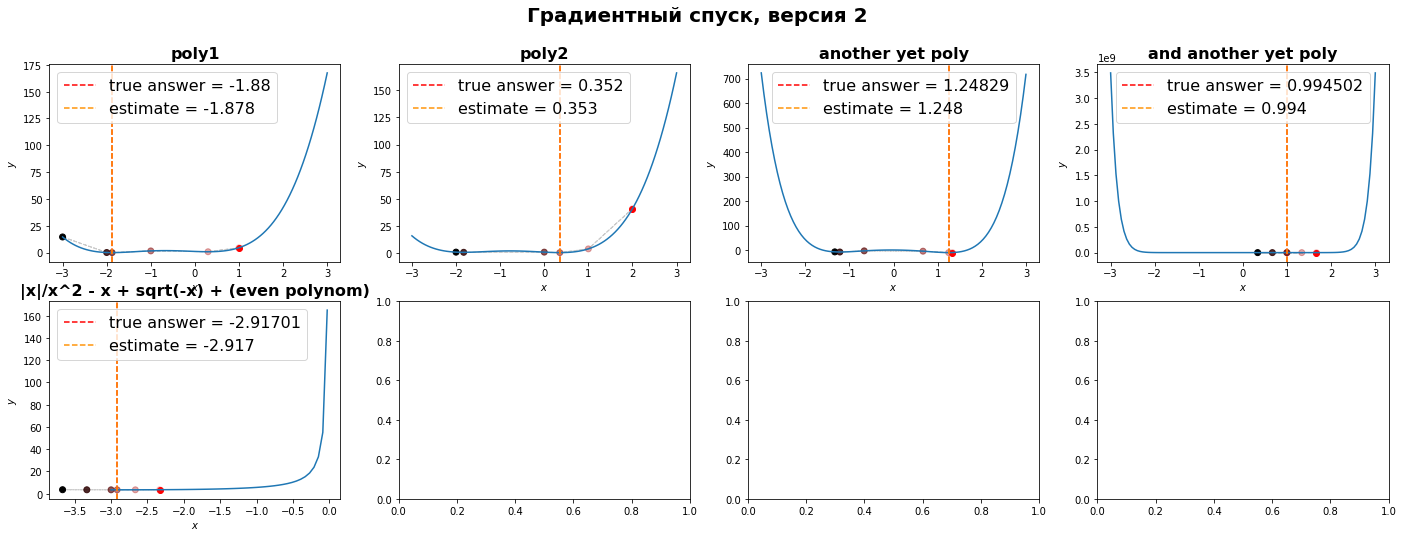

In [8]:
test_cases = {
    "poly1" : {
        "func" : lambda x: x**4 + 3 * x**3 + x**2 - 1.5 * x + 1,
        "deriv" : lambda x: 4 * x**3 + 9 * x**2 + 2 * x - 1.5,
        "low" : -4, "high" : 2, "answer" : -1.88
    },
    "poly2" : {
        "func" : lambda x: x**4 + 3 * x**3 + x**2 - 2 * x + 1.0,
        "deriv" : lambda x: 4 * x**3 + 9 * x**2 + 2 * x - 2.0, 
        "low" : -3, "high" : 3, "answer" : 0.352
    },
    "another yet poly" : {
        "func" : lambda x: x**6 + x**4 - 10 * x**2 - x ,
        "deriv" : lambda x: 6 * x**5 + 4 * x**3 - 20 * x - 1, 
        "low" : -2, "high" : 2, "answer" : 1.24829
    },
    "and another yet poly" : {
        "func" : lambda x: x**20 + x**2 - 20 * x + 10,
        "deriv" : lambda x: 20 * x**19 + 2 * x - 20, 
        "low" : -0, "high" : 2, "answer" : 0.994502
    },
    "|x|/x^2 - x + sqrt(-x) + (even polynom)" : {
        "func" : lambda x: 5 * np.abs(x)/x**2 - 0.5 * x + 0.1 * np.sqrt(-x) + 0.01 * x**2 ,
        "deriv" : lambda x: -0.5 - 0.05/np.sqrt(-x) + 0.02 * x + 5/(x * np.abs(x)) - (10 * np.abs(x))/x**3,
        "low" : -4, "high" : -2, "answer" : -2.91701
    },
}

tol = 1e-2 # желаемая точность

fig, axes = plt.subplots(2,4, figsize=(24, 8))
fig.suptitle("Градиентный спуск, версия 2", fontweight="bold", fontsize=20)
grid = np.linspace(-3, 3, 100)

is_correct, debug_log = test_convergence_1d(
    grad_descent_v2, test_cases, tol, 
    axes, grid
)

if not is_correct:
    print("Не сошлось. Дебажный вывод:")
    for log_entry in debug_log:
        print(log_entry)

​
# Основные положения дифференциального исчисления функций многих переменных

Если вдруг Вы не знаете или не помните дифференциальное исчисление функций многих переменных, то вот несколько ключевых определений. Здесь и ниже рассматриваются скалярные функции многих переменных, т.е. $f:U\rightarrow \mathbb{R}$, где $U$ --- область в $\mathbb{R}^n$. 


Мы хотим ввести некоторый аналог производной. Что мы можем делать уже сейчас --- это вычислять производные функции многих переменных по отдельным аргументам.

## Дифференцируемость функции многих переменных
**Определение**.* Частной производной функции нескольких переменных* $f(x_1,x_2,\ldots, x_n)$ по аргументу $x_i$ в точке $\overline{x^0} = (x_1^0, x_2^0, \ldots, x_n^0)$ называется производная функции $f$ по $x_i$ в точке $x^0_i$ как функции одного аргумента при фиксированных значениях $x_1^0$, $x_2^0, \ldots$, $x_{i-1}^0$, $x_{i+1}^0, \ldots$, $x_n^0$. Иными словами, частная производная равна вот такому пределу:

$$\lim_{h \to 0}\frac{f(x_1,\ldots,x_{i-1}, x_i + h, x_{i+1}, \ldots, x_n) - f(x_1,\ldots,x_n)}{h}.$$

**Обозначение**:

$$f'_{x_i}(\overline{x^0}); \quad \frac{\partial f}{\partial x_i}(\overline{x_0}).$$

**Определение**. Функция $f: \mathbb{R}^n \to \mathbb{R}$ называется *дифференцируемой в точке* $\overline{x^0} = (x_1^0, x_2^0, \ldots, x_n^0)$, если имеет место представление
$$f(\overline{x^0} + \overline{\Delta x}) = f(\overline{x^0}) + \langle \overline{a}, \overline{\Delta x} \rangle + o(|\overline{\Delta x}|),$$ где $\overline{a} \in \mathbb{R}^n$ --- некоторый $n$-мерный вектор, который называется градиентом функции $f$ в точке $\overline{x^0}$. 

**Обозначения для градиента**:
$$\mathrm{grad} f(\overline{x^0}) = \nabla f(\overline{x^0}) = f'(\overline{x^0}).$$

## Связь градиента и частных производных
Как можно заметить, определение выше, во-первых, полностью аналогично свойству производной функции одной переменной. Во-вторых, это определение довольно бесполезно. Оказывается, во всех "хороших" случаях справедливо следующее утверждение.

**Теорема**.
Пусть функция $f$ имеет в точке $\overline{x^0}$ непрерывные частные производные по каждой компоненте $x_i$. Тогда $f$ дифференцируема в точке $\overline{x^0}$, причём её градиент равен вектору из частных производных, то есть 
$$\left(\frac{\partial f}{\partial x_1}(\overline{x^0}), \frac{\partial f}{\partial x_2}(\overline{x^0}), \ldots, \frac{\partial f}{\partial x_n}(\overline{x^0})\right).$$

Суть этой теоремы заключается в том, что во всех ``хороших'' случаях градиент существует и его очень просто вычислить --- нужно просто посчитать частные производные по всем переменным.

**Замечание**.
Градиент указывает на направление наискорейшего роста значения функции. Иными словами, при движении точки, стартующей в $\overline{x^0}$, по вектору $\mathrm{grad} f(\overline{x^0})$, значение функции увеличивается.

 

## Алгоритм градиентного спуска
Алгоритм градиентного спуска для поиска минимума функции $n$ переменных $f(x_1,x_2,\ldots, x_n)$ состоит в итеративном поиске точки минимума функции по формуле для $k+1$-ой точки через $k$-ую точку и градиент в $k$-ой точке.

$$\overline{x}^{k+1} = \overline{x}^k - \lambda\nabla f(\overline{x}^k),$$

где $\lambda$ --- положительное число, называемое learning rate. Обратите внимание, что здесь верхние индексы обозначают не степень, а номер точки в последовательности! То есть под $\overline{x}^k$ понимается вектор $(x^k_1,\ldots, x^k_n)$ --- $k$-ая точка из последовательности приближений, которую строит алгоритм.

​

# Градиентный спуск двумерных хороших функций
А теперь все вместе!

У нас есть только функция, которую нам отдают в качестве аргумента и мы должны найти её минимум.

Мы будем искать глобальный потому, что тут они хорошие.

Нам даны начальные точки, сходимость из которых гарантируется.

Будем использовать следующие параметры:

* Отклонение при вычислении производной $\varepsilon = 10^{-10}$
* Критерий остановки: кол-во итераций $10^4$
* Длина шага градиентного спуска $lr = 0.5$

In [9]:
def numerical_derivative_2d(func, epsilon):
    """
    Функция для приближённого вычисления градиента функции двух переменных. 
    :param func: np.array[2] -> float — произвольная дифференцируемая функция
    :param epsilon: float — максимальная величина приращения по осям
    :return: другая функция, которая приближённо вычисляет градиент в точке
    """
    def grad_func(x):
        """
        :param x: np.array[2] — точка, в которой нужно вычислить градиент
        :return: np.array[2] — приближённое значение градиента в этой точке
        """
        result = np.empty(2)
        result[0] = (func(np.array([x[0] + epsilon, x[1]])) - func(x)) / epsilon
        result[1] = (func(np.array([x[0], x[1] + epsilon])) - func(x)) / epsilon

        return result
    
    return grad_func


def grad_descent_2d(func, low, high, start=None, callback=None):
    """ 
    Реализация градиентного спуска для функций двух переменных 

    Обратите внимание, что здесь градиент функции не дан.
    Его нужно вычислять приближённо.

    :param func: np.ndarray -> float — функция 
    :param low: левая граница интервала по каждой из осей
    :param high: правая граница интервала по каждой из осей
    """
    eps = 1e-10
    df = numerical_derivative_2d(func, eps)
    
    x = start
    iters = int(1e+4)
    lr = 0.5
        
    for i in range(iters):
        x = x - lr / np.sqrt(i + 1) * df(x)
        callback(x, func(x))

    return x

In [10]:
def plot_convergence_2d(func, steps, ax, xlim, ylim, cmap="viridis", title=""):
    """
    Функция отрисовки шагов градиентного спуска. 
    :param func: функция, которая минимизируется градиентным спуском
    :param steps: np.array[N x 2] — шаги алгоритма
    :param ax: холст для отрисовки графика
    :param xlim: tuple(float), 2 — диапазон по первой оси
    :param ylim: tuple(float), 2 — диапазон по второй оси
    :param cmap: str — название палитры
    :param title: str — заголовок графика
    """

    ax.set_title(title, fontsize=20, fontweight="bold")
    # Отрисовка значений функции на фоне
    xrange = np.linspace(*xlim, 100)
    yrange = np.linspace(*ylim, 100)
    grid = np.meshgrid(xrange, yrange)
    X, Y = grid
    fvalues = func(
        np.dstack(grid).reshape(-1, 2)
    ).reshape((xrange.size, yrange.size))
    ax.pcolormesh(xrange, yrange, fvalues, cmap=cmap, alpha=0.8)
    CS = ax.contour(xrange, yrange, fvalues)
    ax.clabel(CS, CS.levels, inline=True)
    # Отрисовка шагов алгоритма в виде стрелочек
    arrow_kwargs = dict(linestyle="--", color="black", alpha=0.8)
    for i, _ in enumerate(steps):
        if i + 1 < len(steps):
            ax.arrow(
                *steps[i],
                *(steps[i+1] - steps[i]),
                **arrow_kwargs
            )
    # Отрисовка шагов алгоритма в виде точек
    n = len(steps)
    color_list = [(i / n, 0, 0, 1 - i / n) for i in range(n)]
    ax.scatter(steps[:, 0], steps[:, 1], c=color_list, zorder=10)
    ax.scatter(steps[-1, 0], steps[-1, 1], 
               color="red", label=f"estimate = {np.round(steps[-1], 2)}")
    # Финальное оформление графиков
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_ylabel("$y$")
    ax.set_xlabel("$x$")
    ax.legend(fontsize=16)

In [11]:
def test_convergence_2d(grad_descent_2d, test_cases, tol, axes=None):
    """
    Функция для проверки корректности нашего решения в двумерном случае.
    :param grad_descent_2d: ваша реализация градиентного спуска
    :param test_cases: dict(dict), тесты в формате dict с такими ключами:
        - "func" — функция 
        - "deriv" — её производная 
        - "low", "high" — диапазон для выбора начальной точки 
        - "answer" — ответ 
    :param tol: предельное допустимое отклонение найденного ответа от истинного
    :param axes: матрица холстов для отрисовки, по ячейке на тест
    :return: флаг, корректно ли пройдены тесты, и дебажный вывод в случае неудачи
    """
    right_flag = True
    debug_log = []
    for i, key in enumerate(test_cases.keys()):
        # Формируем входные данные и ответ для алгоритма.
        answer = test_cases[key]["answer"]
        test_input = deepcopy(test_cases[key])
        del test_input["answer"]
        # Запускаем сам алгоритм.
        callback = LoggingCallback()  # Не забываем про логирование
        res_point = grad_descent_2d(**test_input, callback=callback)
        # Отрисовываем результаты.
        if axes is not None:
            ax = axes[np.unravel_index(i, shape=axes.shape)]
            plot_convergence_2d(
                np.vectorize(test_input["func"], signature="(n)->()"), 
                np.vstack(callback.x_steps), 
                ax=ax, 
                xlim=(test_input["low"], test_input["high"]), 
                ylim=(test_input["low"], test_input["high"]),
                title=key
            )   
        # Проверяем, что найденная точка достаточно близко к истинной
        if np.linalg.norm(answer - res_point, ord=1) > tol:
            debug_log.append(
                f"Тест '{key}':\n"
                f"\t- ответ: {answer}\n"
                f"\t- вывод алгоритма: {res_point}"
            )
            right_flag = False
    return right_flag, debug_log


Не сошлось. Дебажный вывод:
Тест 'straightened ellipses':
	- ответ: [0 3]
	- вывод алгоритма: [-0.03511732  3.001     ]


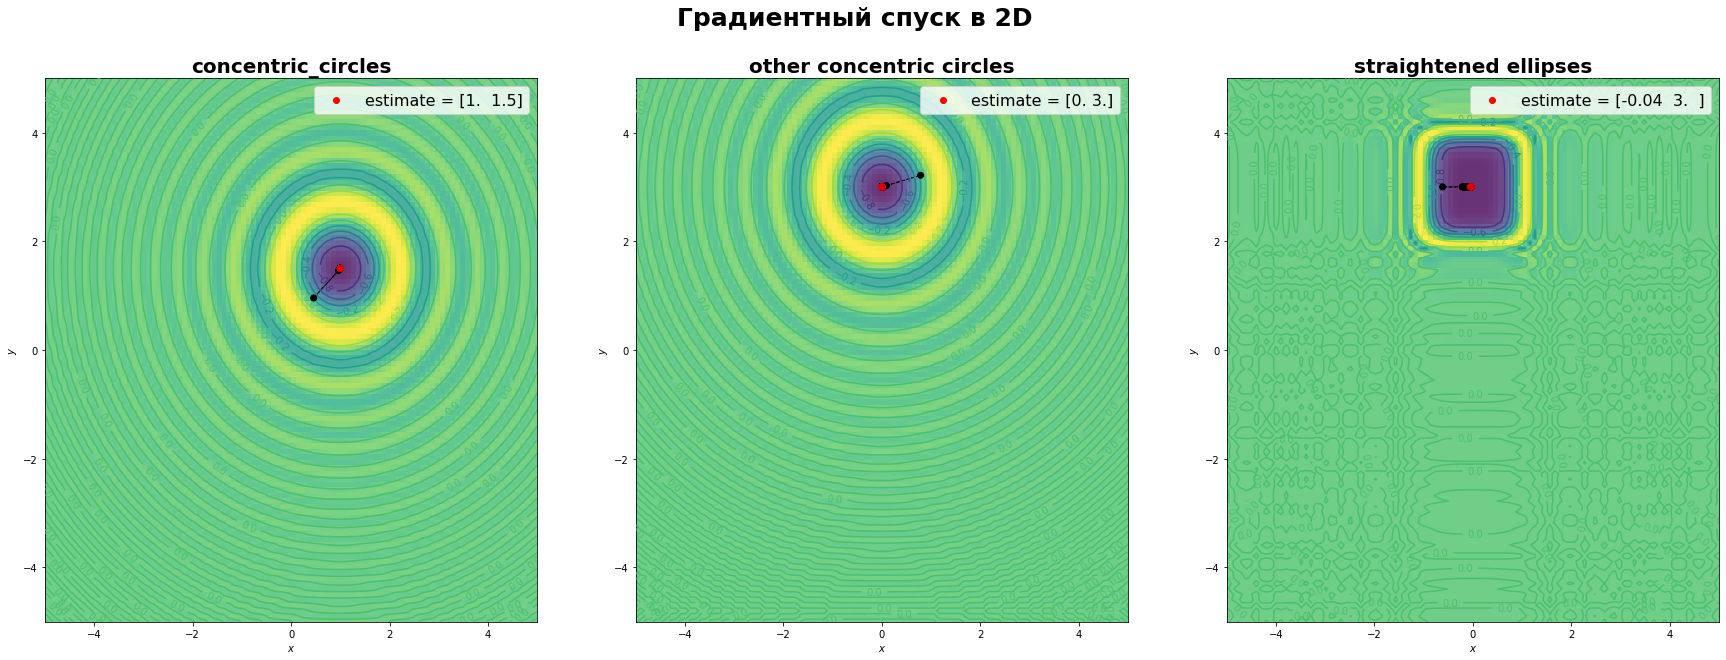

In [12]:
test_cases = {
    "concentric_circles" : {
        "func" : lambda x: (
            -1 / ((x[0] - 1)**2 + (x[1] - 1.5)**2 + 1)
            * np.cos(2 * (x[0] - 1)**2 + 2 * (x[1] - 1.5)**2)
        ),
        "low" : -5,
        "high" : 5,
        "start": np.array([.2 , .7]),
        "answer" : np.array([1, 1.5])
    },
        "other concentric circles" : {
       "func" : lambda x: (
            -1 / ((x[0])**2 + (x[1] - 3)**2 + 1)
            * np.cos(2 * (x[0])**2 + 2 * (x[1] - 3)**2)
        ),
        "low" : -5,
        "high" : 5,
        "start": np.array([1.1, 3.3]),
        "answer" : np.array([0, 3])
    },
    "straightened ellipses" : {
        "func" : lambda x: (
            -1 / ((x[0] )**4 + (x[1] - 3)**6 + 1)
            * np.cos(2 * (x[0])**4 + 2 * (x[1] - 3)**6)
        ),
        "low" : -5,
        "high" : 5,
        "start": np.array([.8, 3.001]), # точка так близко к ответу тк в окрестности ответа градиент маленкьий и функция очень плохо сходится
        "answer" : np.array([0, 3])
    },
}
tol = 1e-2  # желаемая точность

fig, axes = plt.subplots(1, 3, figsize=(30, 10), squeeze=False)
fig.suptitle("Градиентный спуск в 2D", fontsize=25, fontweight="bold")
is_correct, debug_log = test_convergence_2d(grad_descent_2d, test_cases, tol, axes)

if not is_correct:
    print("Не сошлось. Дебажный вывод:")
    for log_entry in debug_log:
        print(log_entry)